This code uses the Cantera library to simulate laminar premixed flames for two or more different fuel compositions. The computation involves setting up the chemical system, solving the flame equations, and refining the grid.
The results, representing velocity profiles versus position, are then plotted on a single graph using Matplotlib.
The code emphasizes modularity by keeping the computation and plotting parts separate, facilitating readability and maintenance.


..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 2 timesteps     1.875e-06      2.283
Attempt Newton solution of steady-state problem...    failure. 
Take 5 timesteps     1.424e-05      2.044
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      1.473
Attempt Newton solution of steady-state problem...    failure. 
Take 20 timesteps        0.5393     -7.109
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
no new points needed in flame

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 2 timesteps      2.25e-05      5.662
Attempt Newton solution of steady-state problem...    failure. 
Take 5 timesteps     0.0001139   

c:\Users\Safari\anaconda3\envs\ct-env\lib\site-packages\cantera\onedim.py:778: FutureWarning: An appropriate transport model
should be set when instantiating the Solution ('gas') object.
Implicit setting of the transport model may be deprecated in the future.
  self.flame = IdealGasFlow(gas, name='flame')


  8.734e-07      5.407
Attempt Newton solution of steady-state problem...    failure. 
Take 80 timesteps         5.029    -0.7132
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 2 3 4 
    to resolve CH4 CO CO2 H2O N2 O2 T velocity 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 2 timesteps     1.875e-06      6.276
Attempt Newton solution of steady-state problem...    failure. 
Take 5 timesteps     4.746e-06      5.686
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.711e-05       6.04
Attempt New

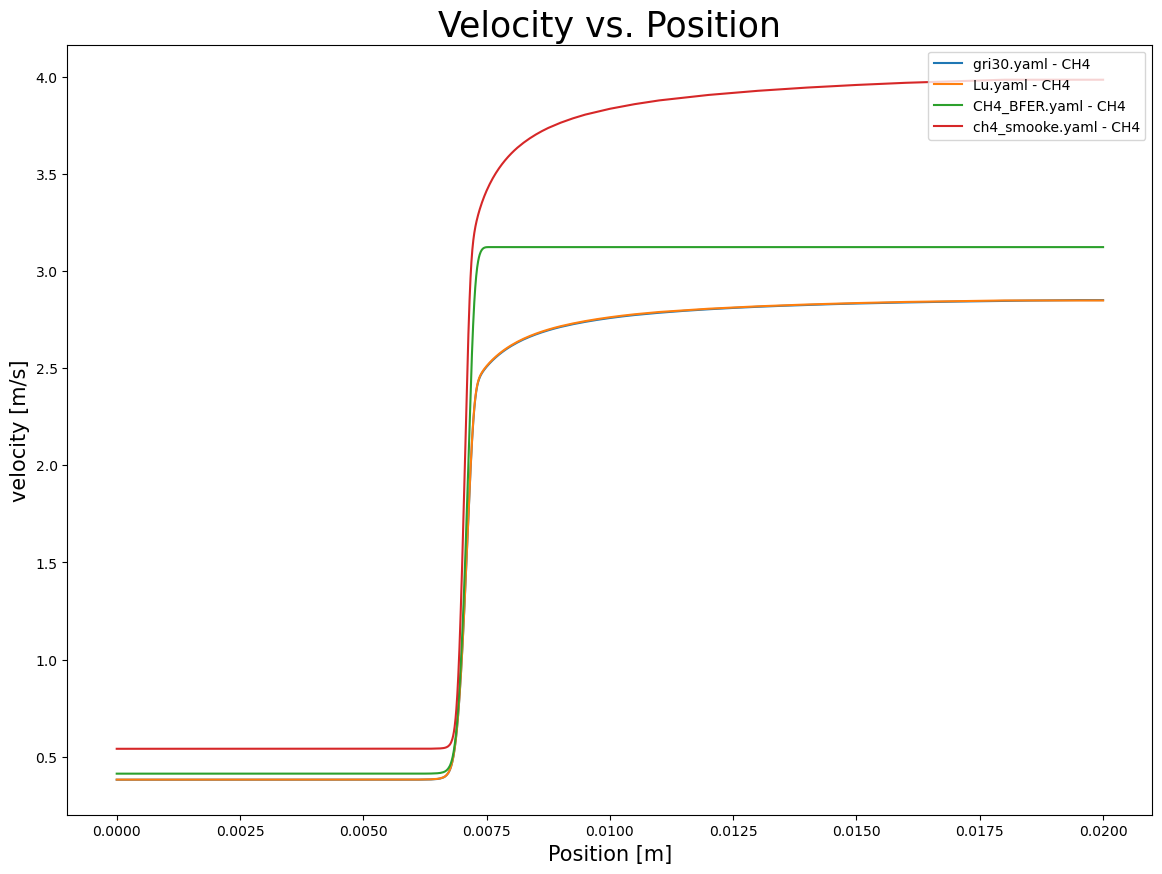

In [1]:
import cantera as ct
import numpy as np
from matplotlib.pylab import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

names = ['gri30.yaml', 'Lu.yaml', 'CH4_BFER.yaml', 'ch4_smooke.yaml']
fuels = ['CH4', 'CH4', 'CH4', 'CH4']

rcParams['figure.figsize'] = (14, 10)
fig, ax = plt.subplots(1, 1)

# Arrays to store statistics for each scheme
flame_speeds = []
flame_speeds_last = []
final_temperatures = []
final_pressures = []
max_densities = []
flame_thicknesses = []
thermal_conductivities = []
heat_capacities = []
heat_release_rates = []
max_heat_release_positions = []

# Computation Part
for i, name in enumerate(names):
    gas = ct.Solution(name)

    p = 1e5
    tin = 300.0
    phi = 1.0

    fuel = {fuels[i]: 1}
    oxidizer = {'O2': 2, 'N2': 7.52}
    HR = []

    gas.TP = tin, p
    gas.set_equivalence_ratio(phi, fuel, oxidizer)

    f = ct.FreeFlame(gas, width=0.02)
    f.inlet.X = gas.X
    f.inlet.T = gas.T
    Ini_T = f.inlet.T
    f.energy_enabled = False

    tol_ss = [1.0e-5, 1.0e-9]
    tol_ts = [1.0e-5, 1.0e-9]

    f.flame.set_steady_tolerances(default=tol_ss)
    f.flame.set_transient_tolerances(default=tol_ts)

    f.set_max_jac_age(50, 50)
    f.set_time_step(1.0e-5, [2, 5, 10, 20, 80])
    f.set_refine_criteria(ratio=10.0, slope=1, curve=1)

    loglevel = 1
    refine_grid = 'disabled'

    f.solve(loglevel, refine_grid)

    f.energy_enabled = True
    refine_grid = 'disabled'

    f.set_refine_criteria(ratio=5.0, slope=0.5, curve=0.5)
    f.solve(loglevel, refine_grid)

    f.set_refine_criteria(ratio=2.0, slope=0.05, curve=0.05)
    f.solve(loglevel, refine_grid)
    
    
    # Statistics
    flame_speeds.append(f.velocity[0])
    flame_speeds_last.append(f.velocity[-1])
    final_temperatures.append(f.T[-1])
    final_pressures.append(f.P)
    max_densities.append(max(f.density))
    flame_thicknesses.append(f.flame.grid[1] - f.flame.grid[0])
    thermal_conductivities.append(f.thermal_conductivity[-1])
    heat_capacities.append(f.cp[-1])
    heat_release_rates.append(max(f.heat_release_rate))
    max_heat_release_positions.append(f.grid[f.heat_release_rate.argmax()])

    # Plotting Part
    z = f.flame.grid
    u = f.velocity
    ifuel = gas.species_index(fuels[i])
    HR.append(-np.dot(gas.net_production_rates, gas.partial_molar_enthalpies))

    ax.plot(z, u, label=f'{names[i]} - {fuels[i]}')

# Finalize Plot
ax.set_title(r'Velocity vs. Position', fontsize=25)
ax.set_xlabel(r'Position [m]', fontsize=15)
ax.set_ylabel("velocity [m/s]", fontsize=15)
ax.legend(loc='upper right')
ax.xaxis.set_major_locator(MaxNLocator(10))

# Save Plot
plt.show()
fig.savefig('Results/Comparison.png')

In [2]:
# Print Statistics
for i, name in enumerate(names):
    print(f"\nStatistics for {name} - {fuels[i]}:")
    print(f"Mixture-Averaged Flame Speed: {flame_speeds[i]:.3f} m/s")
    print(f"Burnt Gas Flame Speed: {flame_speeds_last[i]:.3f} m/s")
    print(f"Final Flame Temperature: {final_temperatures[i]:.3f} K")
    print(f"Final Flame Pressure: {final_pressures[i]:.3f} Pa")
    print(f"Max Density: {max_densities[i]:.3e} (kg/m^3)")
    print(f"Flame Thickness: {flame_thicknesses[i]:.3e} meters")
    print(f"Thermal Conductivity at Flame Front: {thermal_conductivities[i]:.4f} W/m-K")
    print(f"Heat Capacity at Flame Front: {heat_capacities[i]:.3f} J/kg-K")
    print(f"Maximum Heat Release Rate: {heat_release_rates[i]} W/m^3")
    print(f"Position of Maximum Heat Release Rate: {max_heat_release_positions[i]:.5f} meters")


Statistics for gri30.yaml - CH4:
Mixture-Averaged Flame Speed: 0.382 m/s
Burnt Gas Flame Speed: 2.850 m/s
Final Flame Temperature: 2218.182 K
Final Flame Pressure: 100000.000 Pa
Max Density: 1.108e+00 (kg/m^3)
Flame Thickness: 2.000e-03 meters
Thermal Conductivity at Flame Front: 0.1550 W/m-K
Heat Capacity at Flame Front: 1514.395 J/kg-K
Maximum Heat Release Rate: 4408120146.586484 W/m^3
Position of Maximum Heat Release Rate: 0.00723 meters

Statistics for Lu.yaml - CH4:
Mixture-Averaged Flame Speed: 0.383 m/s
Burnt Gas Flame Speed: 2.848 m/s
Final Flame Temperature: 2212.907 K
Final Flame Pressure: 100000.000 Pa
Max Density: 1.108e+00 (kg/m^3)
Flame Thickness: 2.000e-03 meters
Thermal Conductivity at Flame Front: 0.1548 W/m-K
Heat Capacity at Flame Front: 1513.824 J/kg-K
Maximum Heat Release Rate: 4414271264.133018 W/m^3
Position of Maximum Heat Release Rate: 0.00723 meters

Statistics for CH4_BFER.yaml - CH4:
Mixture-Averaged Flame Speed: 0.413 m/s
Burnt Gas Flame Speed: 3.122 m/s
F

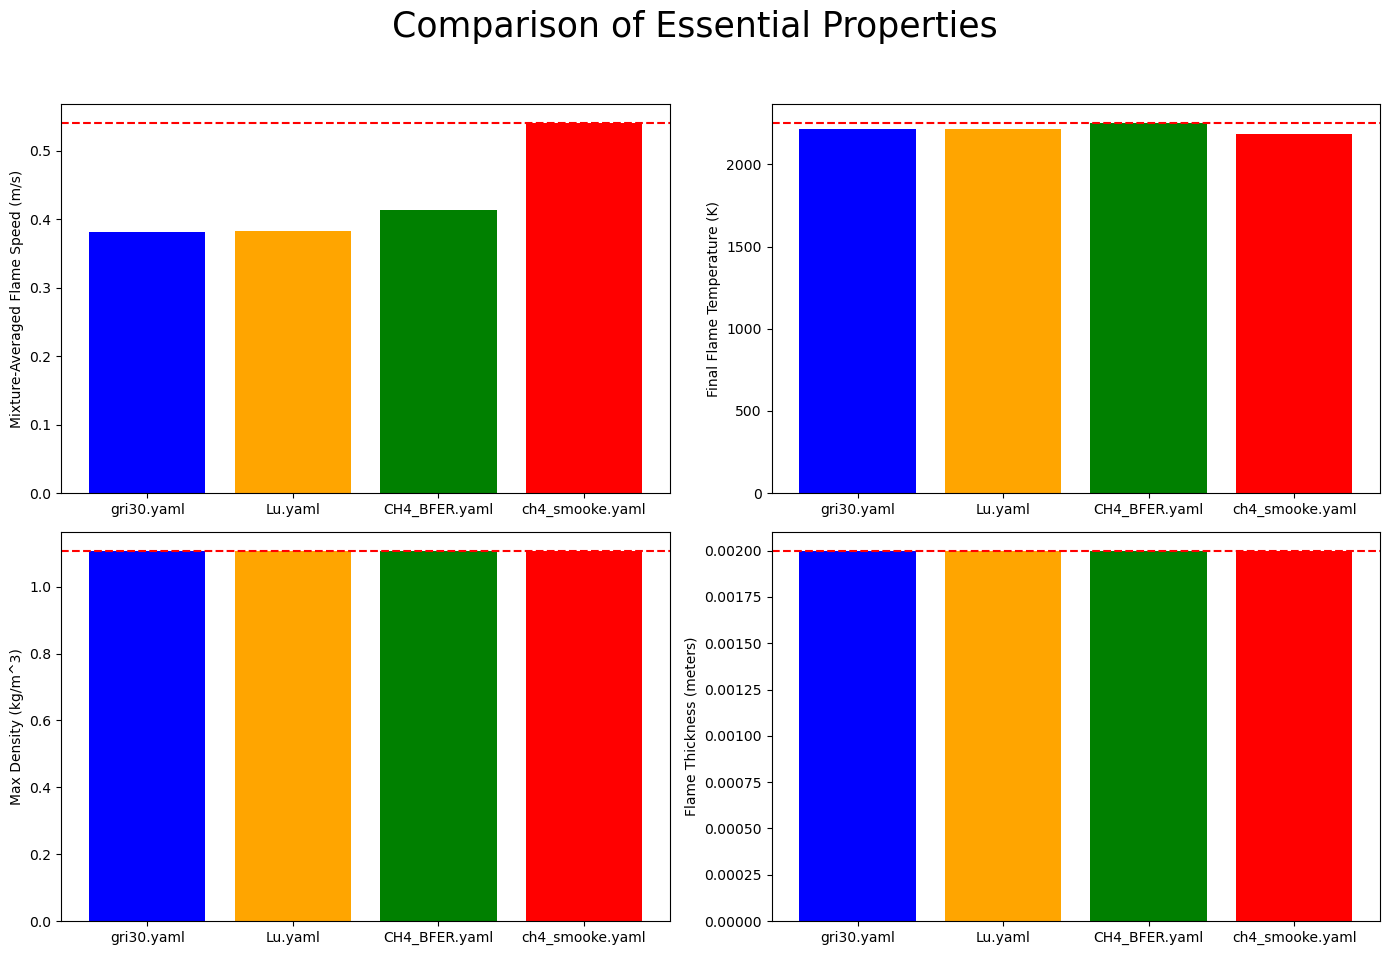

In [3]:
# Create subplots for essential properties comparison
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparison of Essential Properties', fontsize=25)

# Plot Mixture-Averaged Flame Speed
axs[0, 0].bar(names, flame_speeds, color=['blue', 'orange', 'green', 'red'])
axs[0, 0].axhline(max(flame_speeds), color='red', linestyle='--', label='Max Value')
axs[0, 0].set_ylabel('Mixture-Averaged Flame Speed (m/s)')

# Plot Final Flame Temperature
axs[0, 1].bar(names, final_temperatures, color=['blue', 'orange', 'green', 'red'])
axs[0, 1].axhline(max(final_temperatures), color='red', linestyle='--', label='Max Value')
axs[0, 1].set_ylabel('Final Flame Temperature (K)')

# Plot Max Density
axs[1, 0].bar(names, max_densities, color=['blue', 'orange', 'green', 'red'])
axs[1, 0].axhline(max(max_densities), color='red', linestyle='--', label='Max Value')
axs[1, 0].set_ylabel('Max Density (kg/m^3)')

# Plot Flame Thickness
axs[1, 1].bar(names, flame_thicknesses, color=['blue', 'orange', 'green', 'red'])
axs[1, 1].axhline(max(flame_thicknesses), color='red', linestyle='--', label='Max Value')
axs[1, 1].set_ylabel('Flame Thickness (meters)')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show and save the plot
plt.show()
fig.savefig('Results/Properties_Comparison.png')
